In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8,16,32,64,64]

In [6]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs) # lr = 0.4 (highest that worked well)

In [7]:
%time run.fit(2, learn)

train: [1.389404375, tensor(0.5484, device='cuda:0')]
valid: [0.2579200927734375, tensor(0.9190, device='cuda:0')]
train: [0.21038873046875, tensor(0.9365, device='cuda:0')]
valid: [0.12472783203125, tensor(0.9611, device='cuda:0')]
Wall time: 6.8 s


At this point, in order to improve our results we need to apply some kind of normalization.

## Batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bathnorm's momentum is the opposite of what you'd expect (0.1 here is 0.9 in theory)
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True) # we get a mean for each filter
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom) # moving averages
        self.vars.lerp_(v, self.mom) # with exponential decay (momentum)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: 
            m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds # mults = alpha, adds = beta

The function `register_buffer` is like a normal assignation, plus everything in a buffer is saved (and moved to GPU) along with the model.

The normalization is different at inference time: We use exponential moving averages only at inference time (at training time we normalize with the actual values). The momentum is applied there (mu = mom x mu_-1 + (1-mom) x actual), because calculating a moving average taking the N last values would be very costly. This is often called a linear interpolation (`lerp` in PyTorch)

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)] # not bias if bn because batchnorm's beta is like bias!
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [11]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.279636171875, tensor(0.9124, device='cuda:0')]
valid: [0.1123888671875, tensor(0.9641, device='cuda:0')]


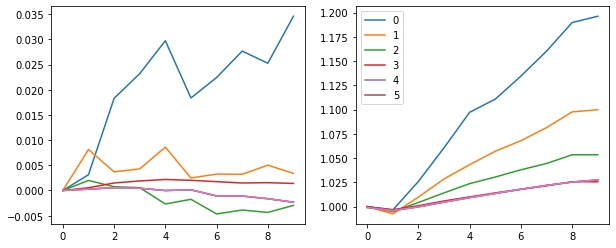

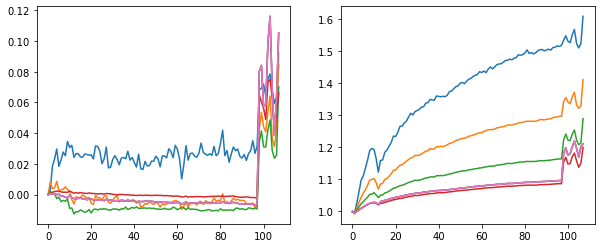

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [13]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [14]:
%time run.fit(3, learn)

train: [0.29757607421875, tensor(0.9053, device='cuda:0')]
valid: [0.1449259521484375, tensor(0.9544, device='cuda:0')]
train: [0.09358259765625, tensor(0.9714, device='cuda:0')]
valid: [0.10717547607421875, tensor(0.9663, device='cuda:0')]
train: [0.0684448779296875, tensor(0.9782, device='cuda:0')]
valid: [0.08962787475585937, tensor(0.9738, device='cuda:0')]
Wall time: 7.32 s


### Builtin batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

We use PyTorch's batchnorm:

In [15]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: 
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.21553923828125, tensor(0.9322, device='cuda:0')]
valid: [0.090603564453125, tensor(0.9704, device='cuda:0')]
train: [0.064786220703125, tensor(0.9794, device='cuda:0')]
valid: [0.07907821044921876, tensor(0.9765, device='cuda:0')]
train: [0.043118359375, tensor(0.9864, device='cuda:0')]
valid: [0.06430164794921875, tensor(0.9823, device='cuda:0')]
Wall time: 6.4 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [19]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [20]:
run.fit(8, learn)

train: [0.24472890625, tensor(0.9263, device='cuda:0')]
valid: [1.262698046875, tensor(0.7956, device='cuda:0')]
train: [0.10045609375, tensor(0.9703, device='cuda:0')]
valid: [0.0732419677734375, tensor(0.9761, device='cuda:0')]
train: [0.0495516650390625, tensor(0.9843, device='cuda:0')]
valid: [0.05890672607421875, tensor(0.9824, device='cuda:0')]
train: [0.0324307666015625, tensor(0.9896, device='cuda:0')]
valid: [0.0531225830078125, tensor(0.9857, device='cuda:0')]
train: [0.01877265869140625, tensor(0.9944, device='cuda:0')]
valid: [0.04733591003417969, tensor(0.9854, device='cuda:0')]
train: [0.01149399169921875, tensor(0.9968, device='cuda:0')]
valid: [0.04264387817382812, tensor(0.9886, device='cuda:0')]
train: [0.00661763427734375, tensor(0.9985, device='cuda:0')]
valid: [0.04266788330078125, tensor(0.9887, device='cuda:0')]
train: [0.004522341003417969, tensor(0.9993, device='cuda:0')]
valid: [0.042290573120117185, tensor(0.9884, device='cuda:0')]


## More norms

### Layer norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*". So we have a problem for example with RNNs, or with pure SGD (bs = 1).

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension (0,2,3) but over the hidden dimension (1,2,3), so it's independent of the batch size (it's a mean of all images mean and std)

In [21]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [22]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: 
        layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [23]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [nan, tensor(0.1524, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 8.28 s


That's not working.

*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones (letters: batch, channel, x, y):

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [25]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [26]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [27]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
Wall time: 8.44 s


*Question*: why can't this classify anything? it's used for style transfer, where the differences in contrast or overall amount are not important.

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

* Batch norm is averaging over the batch images, height and weight (is different for each channel)
* Layer norm over the channels, height and weight (different for each batch element)
* Instance norm over height and weight (different for each batch element and channel)
* Group norm over a group of channels, height and weight

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

BatchNorm is the normalization getting the best results. No idea of what we could do to avoid its problems with RNNs, but there is a solution for small batches :)

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [30]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [31]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [32]:
%time run.fit(1, learn)

train: [2.33791203125, tensor(0.1907, device='cuda:0')]
valid: [128.667875, tensor(0.2867, device='cuda:0')]
Wall time: 3min 46s


Bad results and long execution time :(

### Running Batch Norm

To solve this problem we introduce a **Running BatchNorm** that uses smoother running mean and variance for the mean and std (same normalization applied at training time as well).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5): # eps = "a small number", used to avoid div by 0
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1)) # To calculate variance 
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1)) # as seen on 05a notebook
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.)) # because bs can vary from batch to batch
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.)) # debiasing, to avoid a cold start with moms caused by zero init

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: 
            self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means) # nice!
        if bool(self.batch < 20): # if we haven't seen more than 20 images yet
            vars.clamp_min_(0.01) # do variance at least 0.01 and avoid zero
        x = (x-means).div_((vars.add_(self.eps)).sqrt()) # same normalization for training!
        return x.mul_(self.mults).add_(self.adds)

We could treat epsilon as a hyperparam. A greater value would imply that x never would be so high! We'll back over this idea.

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [35]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [36]:
%time run.fit(1, learn)

train: [0.4659896875, tensor(0.8759, device='cuda:0')]
valid: [0.16502030029296874, tensor(0.9571, device='cuda:0')]
Wall time: 11min 56s


Great result! This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get (tune the parameters!).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [38]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [39]:
%time run.fit(1, learn)

train: [0.15873146484375, tensor(0.9510, device='cuda:0')]
valid: [1.1528724609375, tensor(0.9427, device='cuda:0')]
Wall time: 44.9 s


## Export

In [40]:
nb_auto_export()

<IPython.core.display.Javascript object>